# Law Chatbot Using Retrieval Augmented Generation (RAG)

This project aims to develop a Large Language Model (LLM) with Retrieval Augmented Generation (RAG) support.

Specifically, we'd like to be able to open a PDF file, ask questions (queries) of it and have them answered by a Large Language Model (LLM).

RAG stands for Retrieval Augmented Generation.

It was introduced in the paper [*Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks*](https://arxiv.org/abs/2005.11401).

Each step can be roughly broken down to:

* **Retrieval** - Seeking relevant information from a source given a query. For example, getting relevant passages of Wikipedia text from a database given a question.
* **Augmented** - Using the relevant retrieved information to modify an input to a generative model (e.g. an LLM).
* **Generation** - Generating an output given an input. For example, in the case of an LLM, generating a passage of text given an input prompt.

## Why RAG?

The primary goal of Retrieval-Augmented Generation (RAG) is to enhance the output quality of large language models (LLMs).

Two primary improvements can be seen as:
1. **Preventing hallucinations** - LLMs are powerful but can sometimes generate plausible yet incorrect information. RAG pipelines mitigate this by providing factual inputs, leading to more accurate outputs. Even if the answer from a RAG pipeline is questionable, the retrieval process provides access to the original sources, ensuring transparency.
2. **Work with custom data** - While base LLMs excel at general language tasks due to their broad training on internet-scale text, they often lack specific domain knowledge. RAG systems address this by supplying LLMs with specialized data, such as medical records or corporate documentation, tailoring their outputs to specific applications.

## Setting Up Our Workspace

**Fetching Necessary Libraries**

In [1]:
import os

if "COLAB_GPU" in os.environ:
    print(" Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

 Running in Google Colab, installing requirements.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 39.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.7.3-cp311-cp311-linux_x86_64.whl size=191363917 sha256=b1243e9b86687348a5ab03a073abacdf8e3d5e9e4b7e5326a183f47348c5dfba
  Stored in directory: /root/.cache/pip/wheels/d0/a3/f9/48d2706cb2eac05ec0dc144bf6954fe47bb3c2cd0de280765e
Successfully built flash-attn


## Building Our Pipeline

###  1. Text Processing

Steps:

1. Import the PDF document(s).
2. Prepare the text for embedding by segmenting it into chunks of sentences.

**Importing PDF Documents**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We can import the pages of our PDF(s) as text by first defining the PDF paths and then opening and reading it with PyMuPDF (`import fitz`).

In [3]:
import os

# Get PDF document
dir_path = "/content/drive/MyDrive/Colab Notebooks/LawBot Docs/"

filenames = [] # Loop through the files in the specified directory
for filename in os.listdir(dir_path):
  # Check if it is a file (excluding directories)
  if os.path.isfile(os.path.join(dir_path, filename)):
    filenames.append(os.path.join(dir_path, filename))

In [4]:
filenames[:1]

['/content/drive/MyDrive/Colab Notebooks/LawBot Docs/INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf']

We'll write a small helper function to preprocess the text as it gets read and save each page to a dictionary and then append that dictionary to a list for ease of use later.

> **Resource:** [PyMuPDF](https://github.com/pymupdf/pymupdf)

In [5]:
import fitz # (package name for pymupdf)
from tqdm.auto import tqdm # for progress bars

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("  +", " ") # removing empty spaces
    cleaned_text = text.replace("_+", "") # removing underlines
    cleaned_text = text.replace("\n", " ").strip() # replacing new lines with spaces
    return cleaned_text

# Open PDF and get lines/pages
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the document name, page number,
        character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"doc_name": os.path.basename(pdf_path),
                                "page_number": page_number + 1,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars,
                                "text": text})
    return pages_and_texts

pages_and_texts = []
for filename in filenames:
    pages_and_texts.extend(open_and_read_pdf(pdf_path=filename))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

**Checking out first two pages of the first PDF**

In [6]:
pages_and_texts[:2]

[{'doc_name': 'INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf',
  'page_number': 1,
  'page_char_count': 2370,
  'page_word_count': 397,
  'page_sentence_count_raw': 10,
  'page_token_count': 592.5,
  'text': 'Lesson 1  n Introduction  1 Lesson 1 Introduction LESSON OUTLINE \t –\t Concept of Property vis-à-vis Intellectual  Property \t –\t Concept of Property and Theories of  Property – An Overview \t –\t Theories of Intellectual Property Rights \t –\t Meaning, Relevance, Business Impact,  Protection of Intellectual Property \t –\t Intellectual Property as an Instrument of  Development \t –\t Need for Protecting Intellectual Property \t –\t Policy Consideration \t –\t National and International Perspectives \t –\t Competing Rationales for Protection of  Intellectual Property Rights \t –\t Intellectual Property Rights as Human Right \t –\t Determining Financial Value of Intellectual  Property Rights \t –\t Negotiating Payments Terms in Intellectual  Property Transaction \t –\t Intell

**Getting some statistics**

Let's perform a rough exploratory data analysis (EDA) to get an idea of the size of the texts (e.g. character counts, word counts etc) we're working with.

The different sizes of texts will be a good indicator into how we should split our texts.

In [7]:
import pandas as pd
import random

df = pd.DataFrame(pages_and_texts)
df.sample(n=10)

,doc_name,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
1154,Company Law.pdf,721,2927,526,17,731.75,Lesson 17 n Appointment and Remuneration of Ke...
880,Company Law.pdf,447,4328,762,32,1082.00,Lesson 12 n An overview of Corporate Reorganis...
204,INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf,205,3184,535,20,796.00,Lesson 9 n Patent Infringement 205 with resp...
542,Company Law.pdf,109,3897,676,33,974.25,Lesson 2 n Share and Share Capital 109 \t \t ...
1454,Indian Legal System.pdf,22,3705,658,32,926.25,"INDIAN LEGAL SYSTEM PREPARED BY RADHIKA SETH,..."
1340,Company Law.pdf,907,2803,518,12,700.75,Lesson 22 n Secretarial Standards Board 907 ...
190,INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf,191,3328,590,24,832.00,Lesson 8 n Process of Examination of Patent A...
1070,Company Law.pdf,637,2958,509,16,739.50,Lesson 15 n Board Constitution and its Powers ...
602,Company Law.pdf,169,4269,778,33,1067.25,Lesson 3 n Members and Shareholders 169 perso...
1269,Company Law.pdf,836,2982,495,12,745.50,836 EP-CL Matters not to be dealt with in a...


In [8]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1485.00,1485.00,1485.00,1485.00,1485.00
mean,367.70,3006.93,524.26,15.77,751.73
std,272.51,889.71,151.69,8.30,222.43
min,1.00,11.00,5.00,1.00,2.75
25%,134.00,2640.00,466.00,10.00,660.00
50%,320.00,3175.00,551.00,15.00,793.75
75%,576.00,3565.00,620.00,21.00,891.25
max,947.00,4802.00,864.00,51.00,1200.50


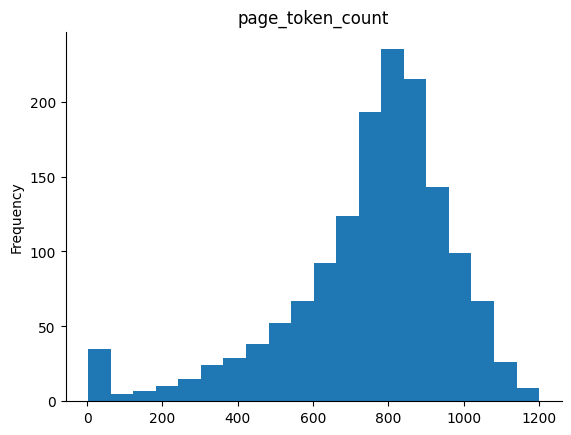

In [9]:
from matplotlib import pyplot as plt
df['page_token_count'].plot(kind='hist', bins=20, title='page_token_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

**Further text processing**

We want to split pages into sentences and chunk them for easier embedding.

Some options for splitting text into sentences:

1. Split into sentences with simple rules (e.g. split on ". " with `text = text.split(". ")`, like we did above).
2. Split into sentences with a natural language processing (NLP) library such as [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).

Why split into sentences?

* Easier to handle than larger pages of text (especially if pages are densely filled with text).
* Can get specific and find out which group of sentences were used to help within a RAG pipeline.

Let's use spaCy to break our text into sentences since it's likely a bit more robust than just using `text.split(". ")`.

> **Resource:** [spaCy install instructions](https://spacy.io/usage).

In [10]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/
nlp.add_pipe("sentencizer")

for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1485 [00:00<?, ?it/s]

In [11]:
pages_and_texts[:4]

[{'doc_name': 'INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf',
  'page_number': 1,
  'page_char_count': 2370,
  'page_word_count': 397,
  'page_sentence_count_raw': 10,
  'page_token_count': 592.5,
  'text': 'Lesson 1  n Introduction  1 Lesson 1 Introduction LESSON OUTLINE \t –\t Concept of Property vis-à-vis Intellectual  Property \t –\t Concept of Property and Theories of  Property – An Overview \t –\t Theories of Intellectual Property Rights \t –\t Meaning, Relevance, Business Impact,  Protection of Intellectual Property \t –\t Intellectual Property as an Instrument of  Development \t –\t Need for Protecting Intellectual Property \t –\t Policy Consideration \t –\t National and International Perspectives \t –\t Competing Rationales for Protection of  Intellectual Property Rights \t –\t Intellectual Property Rights as Human Right \t –\t Determining Financial Value of Intellectual  Property Rights \t –\t Negotiating Payments Terms in Intellectual  Property Transaction \t –\t Intell

Let's review the new statistics.

In [12]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1485.00,1485.00,1485.00,1485.00,1485.00,1485.00
mean,367.70,3006.93,524.26,15.77,751.73,15.92
std,272.51,889.71,151.69,8.30,222.43,8.04
min,1.00,11.00,5.00,1.00,2.75,1.00
25%,134.00,2640.00,466.00,10.00,660.00,10.00
50%,320.00,3175.00,551.00,15.00,793.75,16.00
75%,576.00,3565.00,620.00,21.00,891.25,22.00
max,947.00,4802.00,864.00,51.00,1200.50,57.00


For our set of text, it looks like our raw sentence count (e.g. splitting on `". "`) is quite close to what spaCy came up with.

Why do we do this?

1. Easier to manage similar sized chunks of text.
2. Don't overload the embedding models capacity for tokens (e.g. if an embedding model has a capacity of 384 tokens, there could be information loss if you try to embed a sequence of 400+ tokens).
3. Our LLM context window (the amount of tokens an LLM can take in) may be limited and requires compute power so we want to make sure we're using it as well as possible.

On average each of our pages has ~16 sentences and an average total of ~751 tokens per page.

So if we take groups of 8 sentences, then it will be ~375 tokens long.

This gives us plenty of room for the text to embedded by our `all-mpnet-base-v2` model (it has a capacity of 384 tokens).

In [13]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 8

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1485 [00:00<?, ?it/s]

In [14]:
pages_and_texts[:1]

[{'doc_name': 'INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf',
  'page_number': 1,
  'page_char_count': 2370,
  'page_word_count': 397,
  'page_sentence_count_raw': 10,
  'page_token_count': 592.5,
  'text': 'Lesson 1  n Introduction  1 Lesson 1 Introduction LESSON OUTLINE \t –\t Concept of Property vis-à-vis Intellectual  Property \t –\t Concept of Property and Theories of  Property – An Overview \t –\t Theories of Intellectual Property Rights \t –\t Meaning, Relevance, Business Impact,  Protection of Intellectual Property \t –\t Intellectual Property as an Instrument of  Development \t –\t Need for Protecting Intellectual Property \t –\t Policy Consideration \t –\t National and International Perspectives \t –\t Competing Rationales for Protection of  Intellectual Property Rights \t –\t Intellectual Property Rights as Human Right \t –\t Determining Financial Value of Intellectual  Property Rights \t –\t Negotiating Payments Terms in Intellectual  Property Transaction \t –\t Intell

In [15]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1485.00,1485.00,1485.00,1485.00,1485.00,1485.00,1485.00
mean,367.70,3006.93,524.26,15.77,751.73,15.92,2.44
std,272.51,889.71,151.69,8.30,222.43,8.04,1.02
min,1.00,11.00,5.00,1.00,2.75,1.00,1.00
25%,134.00,2640.00,466.00,10.00,660.00,10.00,2.00
50%,320.00,3175.00,551.00,15.00,793.75,16.00,2.00
75%,576.00,3565.00,620.00,21.00,891.25,22.00,3.00
max,947.00,4802.00,864.00,51.00,1200.50,57.00,8.00


**Creating a new dictionary of individul chunk items**

We aim to embed each chunk of sentences into its unique numerical representation.

To maintain clarity, we will create a list of dictionaries. Each dictionary will contain a single chunk of sentences along with relevant details such as the document name, page number and various statistics about the chunk.

In [16]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["doc_name"] = item["doc_name"]
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# Total no. of chunks
len(pages_and_chunks)

  0%|          | 0/1485 [00:00<?, ?it/s]

3621

In [17]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'doc_name': 'Company Law.pdf',
  'page_number': 114,
  'sentence_chunk': '114  EP-CL continues to stand in his name, should be treated as a trustee for a series of unknown holders of the blank transfer. When he sold his share to the original transferee he could not be deemed to have represented to the transferee anything more than that the share was transferable nor to have agreed to the transferee keeping or passing on the transfer in blank from hand to hand for an indefinite duration, without its being presented to the company for registration. Where a shareholder executes a blank transfer to enable another to deal with the shares, he is bound not to do anything to obstruct registration of the transfer and if he improperly intervenes he is liable in damages, Hooper v. Herts, (1906) 1 Ch 549: (1904-7) ALL ER Rep 849 (CA). Transferor’s right to indemnity for calls - Where a transferor has paid for calls to the company after the shares are transferred, there arises an implied promise 

In [18]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,3621.00,3621.00,3621.00,3621.00
mean,350.44,1219.18,201.74,304.79
std,276.66,707.07,118.31,176.77
min,1.00,3.00,1.00,0.75
25%,113.00,743.00,121.00,185.75
50%,285.00,1147.00,189.00,286.75
75%,548.00,1576.00,262.00,394.00
max,947.00,4246.00,732.00,1061.50


It seems that some of our chunks have a relatively low token count.

Let's review the samples with fewer than 70 tokens (approximately the length of a sentence) to determine if they are worth retaining.

In [19]:
# Show random chunks with under 70 tokens in length
min_token_length = 70
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 29.0 | Text: For instance,the shareholders can institute class action against the company as well as the auditors of the company.
Chunk token count: 62.25 | Text: 826  EP-CL   	 9.	 At a general meeting, two joint holders voted on a resolution. Will the votes of both the joint holders be accepted?	 10.	 What are the provision of the Companies Act, in regard to the holding of an Extra Ordinary General Meeting?
Chunk token count: 43.5 | Text: What is the process of formulating Secretarial Standards?	 2.	 What are the functions of Secretarial Standards Board?	 3.	 What is the need and scope of Secretarial Standard?
Chunk token count: 53.5 | Text: SC] Civil Appeal Nos.5743-5745 of 2005 Aftab Alam & R. M. Lodha, JJ.[Decided on 09.11.2010] Brief facts: In January 2001, the Appellant filed a suit before the Madras High Court for permanent injunction restraining
Chunk token count: 69.0 | Text: 250  EP-CL 	 b.	 for creating a charge on the company’s assets and properties 	 	 

These don't seem to offer too much information.

Let's filter our DataFrame/list of dictionaries to only include chunks with over 70 tokens in length.

In [20]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'doc_name': 'INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf',
  'page_number': 1,
  'sentence_chunk': 'Lesson 1 n Introduction 1 Lesson 1 Introduction LESSON OUTLINE \t –\t Concept of Property vis-à-vis Intellectual Property \t –\t Concept of Property and Theories of Property – An Overview \t –\t Theories of Intellectual Property Rights \t –\t Meaning, Relevance, Business Impact, Protection of Intellectual Property \t –\t Intellectual Property as an Instrument of Development \t –\t Need for Protecting Intellectual Property \t –\t Policy Consideration \t –\t National and International Perspectives \t –\t Competing Rationales for Protection of Intellectual Property Rights \t –\t Intellectual Property Rights as Human Right \t –\t Determining Financial Value of Intellectual Property Rights \t –\t Negotiating Payments Terms in Intellectual Property Transaction \t –\t Intellectual Property Rights in the Cyber World \t –\t Lesson Round-Up \t –\t Self-Test Questions LEARNING OBJECTIVES Ov

### 2. Embedding Creation

Embeddings are numerical representations of data that capture the underlying relationships and patterns within the data. They convert complex, high-dimensional data into lower-dimensional vectors that can be easily processed by machine learning models.

Steps:
1. Use an embedding model to embed the text chunks.
2. Save the embeddings to a file for future reference, ensuring they are preserved.

Our goal is to turn each of our chunks into a numerical representation (an embedding vector, where a vector is a sequence of numbers arranged in order). To do so, we'll use the sentence-transformers library which contains many pre-trained embedding models. Specifically, we'll get the `all-mpnet-base-v2` model.

> **Resource:** [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#intended-uses).

In [21]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cuda")

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  0%|          | 0/3323 [00:00<?, ?it/s]

In [22]:
pages_and_chunks_over_min_token_len[:1]

[{'doc_name': 'INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf',
  'page_number': 1,
  'sentence_chunk': 'Lesson 1 n Introduction 1 Lesson 1 Introduction LESSON OUTLINE \t –\t Concept of Property vis-à-vis Intellectual Property \t –\t Concept of Property and Theories of Property – An Overview \t –\t Theories of Intellectual Property Rights \t –\t Meaning, Relevance, Business Impact, Protection of Intellectual Property \t –\t Intellectual Property as an Instrument of Development \t –\t Need for Protecting Intellectual Property \t –\t Policy Consideration \t –\t National and International Perspectives \t –\t Competing Rationales for Protection of Intellectual Property Rights \t –\t Intellectual Property Rights as Human Right \t –\t Determining Financial Value of Intellectual Property Rights \t –\t Negotiating Payments Terms in Intellectual Property Transaction \t –\t Intellectual Property Rights in the Cyber World \t –\t Lesson Round-Up \t –\t Self-Test Questions LEARNING OBJECTIVES Ov

To improve the speed of embedding creation we can perform batched operations by turning our target text samples into a single list and then passing that list to our embedding model.

In [23]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32,
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

tensor([[ 0.0363, -0.0079,  0.0031,  ..., -0.0219, -0.0010, -0.0123],
        [ 0.0127,  0.0207,  0.0109,  ..., -0.0290, -0.0136,  0.0318],
        [-0.0065, -0.0255, -0.0074,  ..., -0.0317,  0.0028,  0.0266],
        ...,
        [ 0.0398,  0.0328,  0.0299,  ...,  0.0674, -0.0272,  0.0025],
        [ 0.0364, -0.0357, -0.0057,  ...,  0.0091, -0.0730,  0.0246],
        [ 0.0341, -0.0388,  0.0082,  ..., -0.0133, -0.0136,  0.0118]],
       device='cuda:0')

**Saving embeddings to a file**

1.   List item
2.   List item



In [24]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "/content/drive/MyDrive/Colab Notebooks/text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [25]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,doc_name,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf,1,Lesson 1 n Introduction 1 Lesson 1 Introductio...,2187,335,546.75,[ 3.62676382e-02 -7.86000118e-03 3.10870772e-...
1,INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf,2,2 PP-IPRL&P CONCEPT OF PROPERTY VIS-À-VIS INT...,1041,155,260.25,[ 1.26582468e-02 2.06503533e-02 1.08686751e-...
2,INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf,2,"Industrial property, which includes inventions...",1322,188,330.50,[-6.47391146e-03 -2.55206469e-02 -7.39933923e-...
3,INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf,3,Lesson 1 n Introduction 3 have been brought un...,1251,201,312.75,[ 4.90217544e-02 1.77319534e-02 8.05821177e-...
4,INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf,3,CONCEPT OF PROPERTY AND THEORIES OF PROPERTY –...,1313,240,328.25,[ 1.77580956e-02 4.76788916e-02 4.44614738e-...
